In [1]:
import collections
import json
import datetime
import squarify
import dacite
import matplotlib.pyplot as plt
from src.config import get_config
from src.domain import CrossChainMevExtraction
from src.domain import PolygonBridgeInteraction
from src.blockchains.ethereum import EthereumService
from src.blockchains.polygon import PolygonService
file_path = 'extractions_result-18500000-19500000.json'

def json_to_cross_chain_mev_extraction_object(
        data: dict) -> CrossChainMevExtraction:
    return dacite.from_dict(
        data_class=CrossChainMevExtraction, data=data,
        config=dacite.Config(cast=[PolygonBridgeInteraction]))


def load_cross_chain_mev_extractions_from_file(
        file_path: str) -> list[CrossChainMevExtraction]:
    with open(file_path, 'r') as file:
        data_list = json.load(file)
    cross_chain_mev_extractions = []
    for data in data_list:
        try:
            cross_chain_mev_extractions.append(
                json_to_cross_chain_mev_extraction_object(data))
        except Exception:
            pass
    return cross_chain_mev_extractions



config = get_config()
ethereum_service = EthereumService(get_config()['URL']['ethereum'])
polygon_service = PolygonService(get_config()['URL']['polygon'])
cross_chain_mev_extractions = load_cross_chain_mev_extractions_from_file(
    file_path)
cyclic_arbs = [
    extraction for extraction in cross_chain_mev_extractions
    if extraction.is_cyclic_arbitrage
]

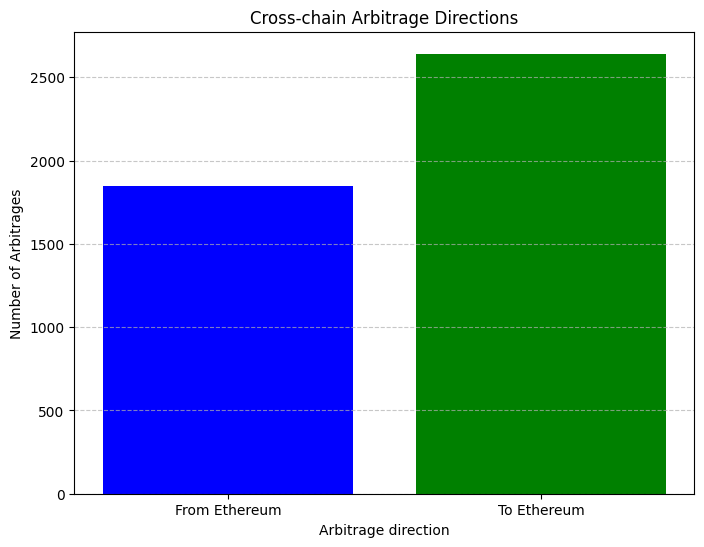

In [2]:
direction_counter = collections.Counter(
    extraction.direction for extraction in cross_chain_mev_extractions)
directions = ['From Ethereum', 'To Ethereum']
number_of_arbitrages = [direction_counter[1], direction_counter[2]]
plt.figure(figsize=(8, 6))
plt.bar(directions, number_of_arbitrages, color=['blue', 'green'])
plt.xlabel('Arbitrage direction')
plt.ylabel('Number of Arbitrages')
plt.title('Cross-chain Arbitrage Directions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

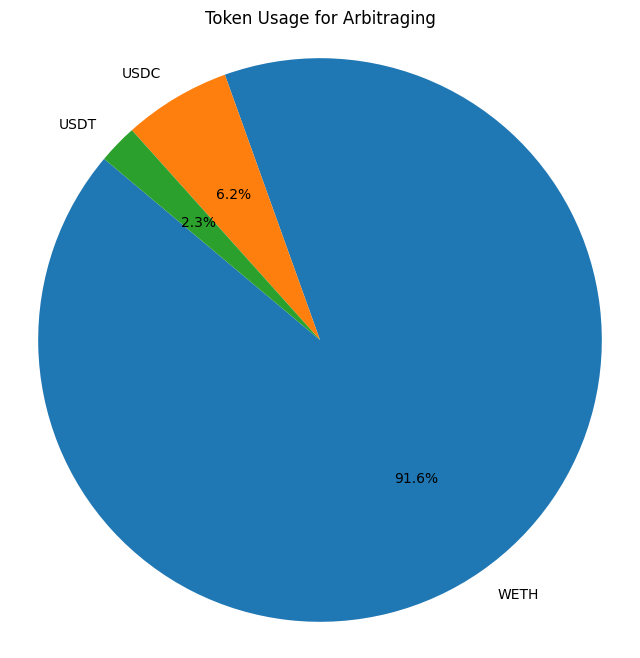

In [3]:
counter = collections.Counter(extraction.profit_token_symbol
                              for extraction in cyclic_arbs)
tokens = list(counter.keys())
usage_counts = list(counter.values())
plt.figure(figsize=(8, 8))  # Set the figure size (optional)
plt.pie(usage_counts, labels=tokens, autopct='%1.1f%%', startangle=140)
plt.title('Token Usage for Arbitraging')
plt.axis('equal')
plt.show()

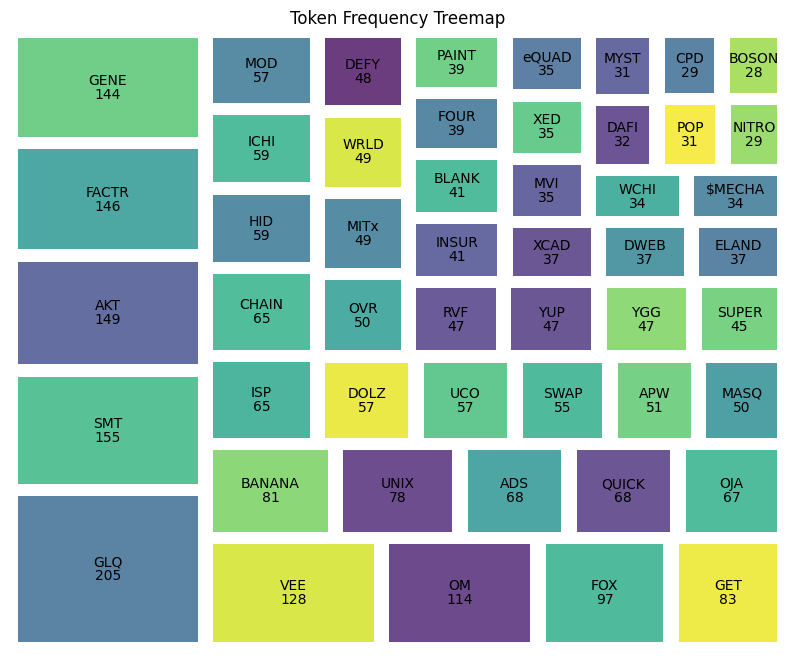

In [4]:
counter = collections.Counter(
    extraction.ethereum_leg.token_address
    for extraction in cross_chain_mev_extractions).most_common(50)
dict_counter = dict(counter)
new_dict = {}
for key in dict_counter:
    token_symbol = ethereum_service.get_token_symbol_and_parsed_amount(key,
                                                                       0)[0]
    new_dict[token_symbol] = dict_counter[key]
labels = list(new_dict.keys())
sizes = list(new_dict.values())
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
squarify.plot(sizes=sizes, label=labels, value=sizes, pad=True, alpha=0.8)
plt.title('Token Frequency Treemap')
plt.axis('off')  # Hide axis
plt.show()

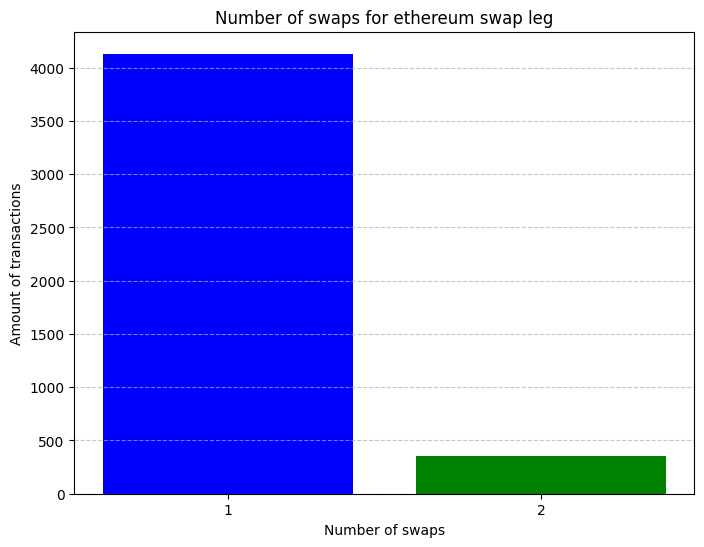

In [5]:
counter_etherum = collections.Counter(
    len(extraction.ethereum_leg.swaps)
    for extraction in cross_chain_mev_extractions)
plt.figure(figsize=(8, 6))
plt.bar([str(key) for key in counter_etherum.keys()], counter_etherum.values(), color=['blue', 'green'])
plt.xlabel('Number of swaps')
plt.ylabel('Amount of transactions')
plt.title('Number of swaps for ethereum swap leg')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

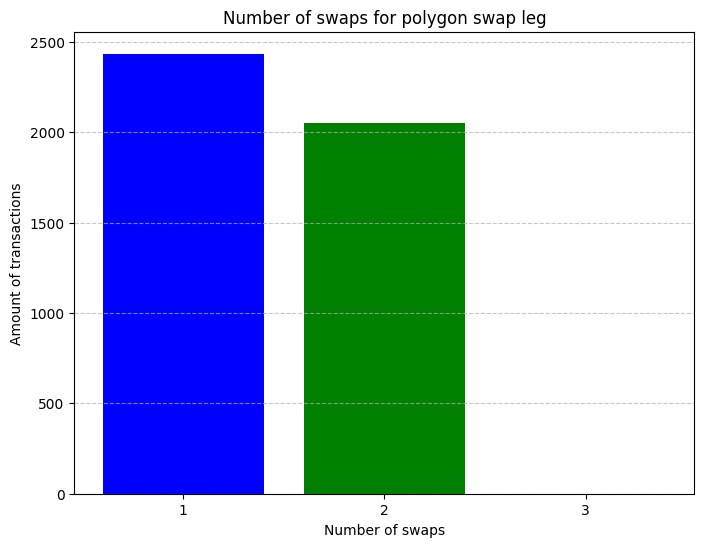

In [6]:
counter_polygon = collections.Counter(
    len(extraction.polygon_leg.swaps)
    for extraction in cross_chain_mev_extractions)
plt.figure(figsize=(8, 6))
plt.bar([str(key) for key in counter_polygon.keys()], counter_polygon.values(), color=['blue', 'green'])
plt.xlabel('Number of swaps')
plt.ylabel('Amount of transactions')
plt.title('Number of swaps for polygon swap leg')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

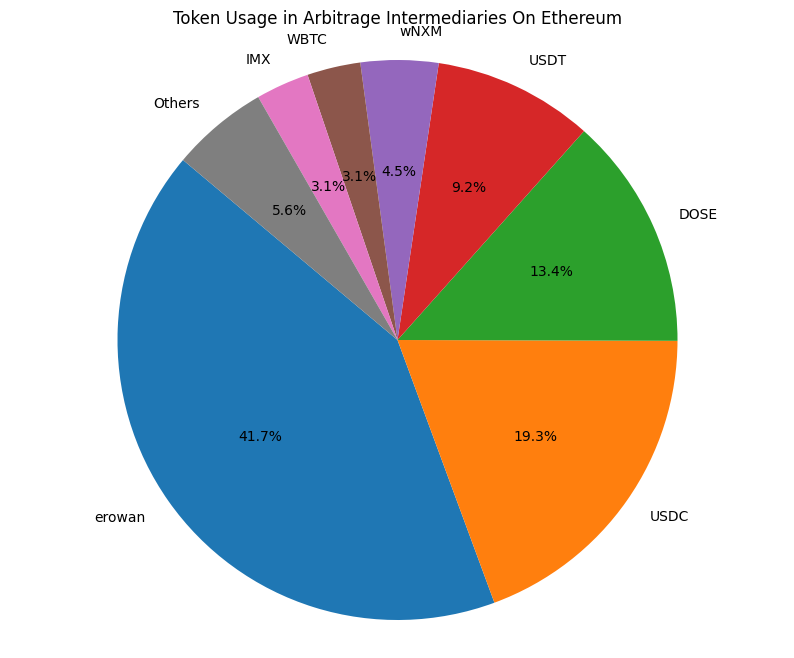

In [7]:
token_counter_ethereum = collections.defaultdict(lambda: 0)
threshold = 7
for extraction in cross_chain_mev_extractions:
    if len(extraction.ethereum_leg.swaps) > 1:
        for swap in extraction.ethereum_leg.swaps[:-1]:
            token_counter_ethereum[swap.token_out] += 1
token_counter_symbol_dict_ethereum = {}
for token in token_counter_ethereum:
    token_counter_symbol_dict_ethereum[
        ethereum_service.get_token_symbol_and_parsed_amount(
            token, 0)[0]] = token_counter_ethereum[token]
sorted_tokens = sorted(token_counter_symbol_dict_ethereum.items(), key=lambda x: x[1], reverse=True)
tokens = [token for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    other_count = sum(count for count in counts[threshold:])
    tokens = tokens[:threshold] + ['Others']
    counts = counts[:threshold] + [other_count]
# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=tokens, autopct='%1.1f%%', startangle=140)
plt.title('Token Usage in Arbitrage Intermediaries On Ethereum')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

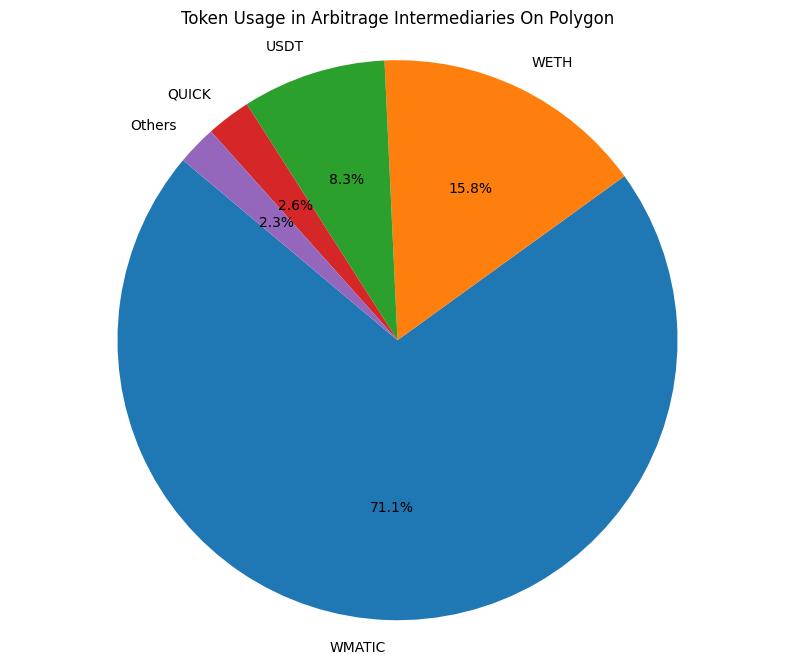

In [8]:
token_counter_polygon = collections.defaultdict(lambda: 0)
for extraction in cross_chain_mev_extractions:
    if len(extraction.polygon_leg.swaps) > 1:
        for swap in extraction.polygon_leg.swaps[:-1]:
            token_counter_polygon[swap.token_out] += 1
token_counter_symbol_dict_polygon = {}
for token in token_counter_polygon:
    token_counter_symbol_dict_polygon[
        polygon_service.get_token_symbol_and_parsed_amount(
            token, 0)[0]] = token_counter_polygon[token]
sorted_tokens = sorted(token_counter_symbol_dict_polygon.items(), key=lambda x: x[1], reverse=True)
threshold = 4
tokens = [token for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    other_count = sum(count for count in counts[threshold:])
    tokens = tokens[:threshold] + ['Others']
    counts = counts[:threshold] + [other_count]
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=tokens, autopct='%1.1f%%', startangle=140)
plt.title('Token Usage in Arbitrage Intermediaries On Polygon')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

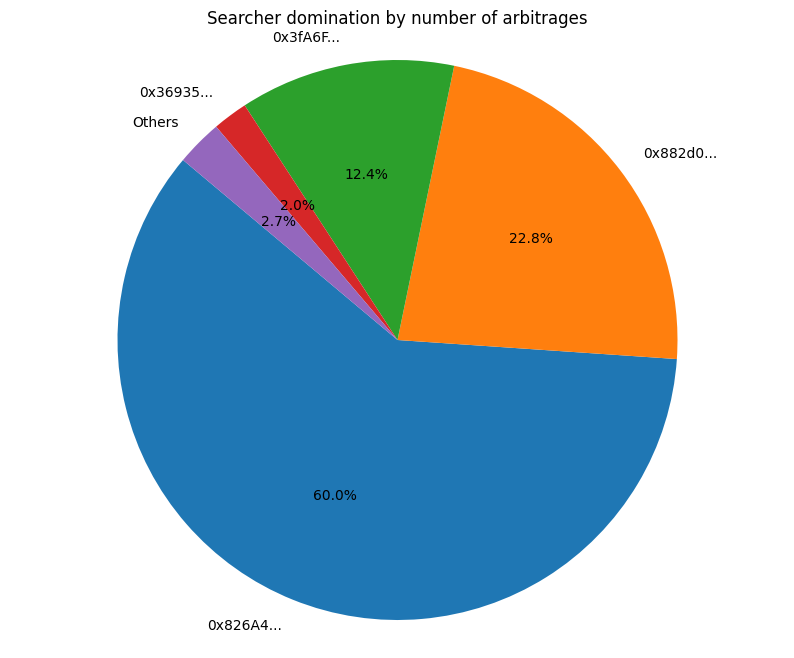

In [9]:
counter_ethereum = collections.Counter(
    extraction.ethereum_leg.searcher_contract_address
    for extraction in cross_chain_mev_extractions)
sorted_tokens = sorted(counter_ethereum.items(), key=lambda x: x[1], reverse=True)
threshold = 4
tokens = [f'{token[:7]}...' for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    other_count = sum(count for count in counts[threshold:])
    tokens = tokens[:threshold] + ['Others']
    counts = counts[:threshold] + [other_count]
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=tokens, autopct='%1.1f%%', startangle=140)
plt.title('Searcher domination by number of arbitrages')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

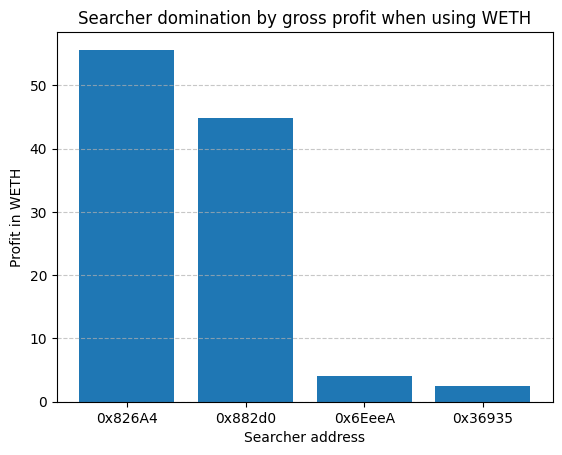

In [10]:
profit_dict_eth = collections.defaultdict(lambda: 0)
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'WETH':
        profit_dict_eth[extraction.ethereum_leg.searcher_contract_address] += float(extraction.profit_amount)
threshold = 4
sorted_tokens = sorted(profit_dict_eth.items(), key=lambda x: x[1], reverse=True)
tokens = [token[:7] for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    tokens = tokens[:threshold] 
    counts = counts[:threshold]
plt.bar(tokens, counts)
plt.xlabel('Searcher address')
plt.ylabel('Profit in WETH')
plt.title('Searcher domination by gross profit when using WETH')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

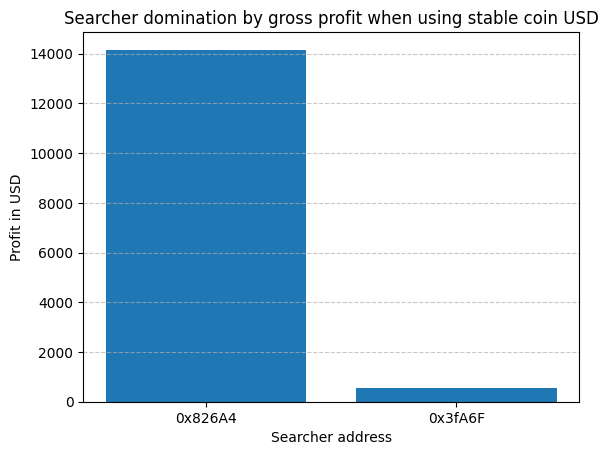

In [11]:
profit_dict_usd = collections.defaultdict(lambda: 0)
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'USDC' or extraction.profit_token_symbol == 'USDT':
        profit_dict_usd[extraction.ethereum_leg.searcher_contract_address] += float(extraction.profit_amount)
sorted_tokens = sorted(profit_dict_usd.items(), key=lambda x: x[1], reverse=True)
tokens = [token[:7] for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
plt.bar(tokens, counts)
plt.xlabel('Searcher address')
plt.ylabel('Profit in USD')
plt.title('Searcher domination by gross profit when using stable coin USD')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

average profit per transaction: 0.02995805211301955 WETH
max profit: 1.835639759159791 WETH
tx hashes ('0xc8e47f347b59fe8fe2c22be0679d5ea491373e8368c57bb092fa24087fbef386', '0x38d230c08cef4473a83f27ba534b282251e65e4bf71a1acf381796bc247539ac', '0x38d230c08cef4473a83f27ba534b282251e65e4bf71a1acf381796bc247539ac')
min profit: -0.6111703010773278 WETH
tx hashes ('0xc8e47f347b59fe8fe2c22be0679d5ea491373e8368c57bb092fa24087fbef386', '0x38d230c08cef4473a83f27ba534b282251e65e4bf71a1acf381796bc247539ac', '0x38d230c08cef4473a83f27ba534b282251e65e4bf71a1acf381796bc247539ac')


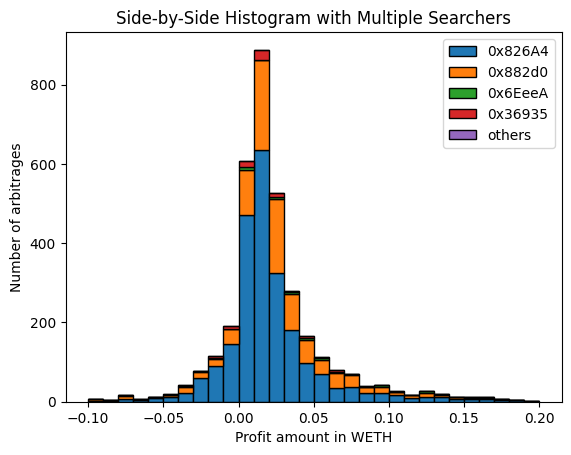

In [12]:
profit_dict_eth = collections.defaultdict(lambda: 0)
number_of_arbitrages = 0
total_volume = 0
max_profit = 0
min_profit = 0
tx_hash_max_profit = ''
tx_hash_min_profit = ''
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'WETH':
        if float(extraction.profit_amount) > max_profit:
            max_profit = float(extraction.profit_amount)
            tx_hash_max_profit = (
                extraction.ethereum_leg.transaction_hash,
                extraction.polygon_leg.bridge_transaction_hash,
                extraction.polygon_leg.swap_transaction_hash)
        if float(extraction.profit_amount) < min_profit:
            min_profit = float(extraction.profit_amount)
            tx_hash_min_profit = (
                extraction.ethereum_leg.transaction_hash,
                extraction.polygon_leg.bridge_transaction_hash,
                extraction.polygon_leg.swap_transaction_hash)
        number_of_arbitrages += 1
        total_volume += float(extraction.profit_amount)
        profit_dict_eth[
            extraction.ethereum_leg.searcher_contract_address] += float(
                extraction.profit_amount)
sorted_tokens = sorted(profit_dict_eth.items(), key=lambda x: x[1],
                       reverse=True)
top_4_searchers = [searcher for searcher, _ in sorted_tokens][:4]
di = collections.defaultdict(lambda: [])
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'WETH':
        searcher = extraction.ethereum_leg.searcher_contract_address
        if searcher not in top_4_searchers:
            searcher = 'others'
        di[searcher].append(float(extraction.profit_amount))
list_to_plot = [di[searcher] for searcher in top_4_searchers]
list_to_plot.append(di['others'])
plt.hist(list_to_plot, bins=30, range=(-0.1, 0.2),
         label=[s[:7] for s in top_4_searchers] + ['others'], stacked=True,
         edgecolor='black')
plt.legend()
plt.xlabel('Profit amount in WETH')
plt.ylabel('Number of arbitrages')
plt.title('Side-by-Side Histogram with Multiple Searchers')

print("average profit per transaction:", total_volume / number_of_arbitrages, "WETH")
print("max profit:", max_profit, "WETH")
print("tx hashes", tx_hash_max_profit)
print("min profit:", min_profit, "WETH")
print("tx hashes", tx_hash_max_profit)

plt.show()

average profit per transaction: 45.138811524999454 USD
max profit: 708.681208 USD
tx hashes ('0xc95541b1b74751afd2d7c6eb4df6df5de37bc9be8fe3dae1673095c50f84a624', '0x0d6115322025a777938e16888e55671556d2921419df4abee9a72bbe149ee7ec', '0x0d6115322025a777938e16888e55671556d2921419df4abee9a72bbe149ee7ec')
min profit: -443.482519 USD
tx hashes ('0xc95541b1b74751afd2d7c6eb4df6df5de37bc9be8fe3dae1673095c50f84a624', '0x0d6115322025a777938e16888e55671556d2921419df4abee9a72bbe149ee7ec', '0x0d6115322025a777938e16888e55671556d2921419df4abee9a72bbe149ee7ec')


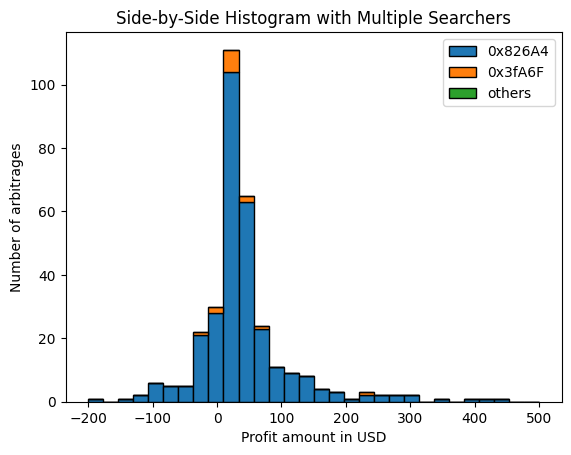

In [13]:
profit_dict_usd= collections.defaultdict(lambda: 0)
number_of_arbitrages = 0
max_profit = 0
min_profit = 0
tx_hash_max_profit = ''
tx_hash_min_profit = ''
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'USDC' or extraction.profit_token_symbol == 'USDT':
        if float(extraction.profit_amount) > max_profit:
            max_profit = float(extraction.profit_amount)
            tx_hash_max_profit = (
                extraction.ethereum_leg.transaction_hash,
                extraction.polygon_leg.bridge_transaction_hash,
                extraction.polygon_leg.swap_transaction_hash)
        if float(extraction.profit_amount) < min_profit:
            min_profit = float(extraction.profit_amount)
            tx_hash_min_profit = (
                extraction.ethereum_leg.transaction_hash,
                extraction.polygon_leg.bridge_transaction_hash,
                extraction.polygon_leg.swap_transaction_hash)
        number_of_arbitrages += 1
        total_volume += float(extraction.profit_amount)
        profit_dict_usd[extraction.ethereum_leg.searcher_contract_address] += float(extraction.profit_amount)
sorted_tokens = sorted(profit_dict_usd.items(), key=lambda x: x[1], reverse=True)
top_4_searchers = [searcher for searcher, _ in sorted_tokens][:4]
di = collections.defaultdict(lambda: [])
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'USDC' or extraction.profit_token_symbol == 'USDT':
        searcher = extraction.ethereum_leg.searcher_contract_address
        if searcher not in top_4_searchers:
            searcher = 'others'
        di[searcher].append(float(extraction.profit_amount))
list_to_plot = [di[searcher] for searcher in top_4_searchers]
list_to_plot.append(di['others'])
plt.hist(list_to_plot, bins=30, range=(-200, 500), label=[s[:7] for s in top_4_searchers] + ['others'], stacked=True, edgecolor = 'black')
plt.legend()
plt.xlabel('Profit amount in USD')
plt.ylabel('Number of arbitrages')
plt.title('Side-by-Side Histogram with Multiple Searchers')

print("average profit per transaction:", total_volume / number_of_arbitrages, "USD")
print("max profit:", max_profit, "USD")
print("tx hashes", tx_hash_max_profit)
print("min profit:", min_profit, "USD")
print("tx hashes", tx_hash_max_profit)

plt.show() 

In [14]:
additional_info_ethereum = []
additional_info_polygon = []
for extraction in cross_chain_mev_extractions:
    additional_info_polygon.append(
        polygon_service.get_transaction_timestamp_and_gas_price(
            extraction.polygon_leg.swap_transaction_hash))
    additional_info_ethereum.append(
        ethereum_service.get_transaction_timestamp_and_gas_price(
            extraction.ethereum_leg.transaction_hash))

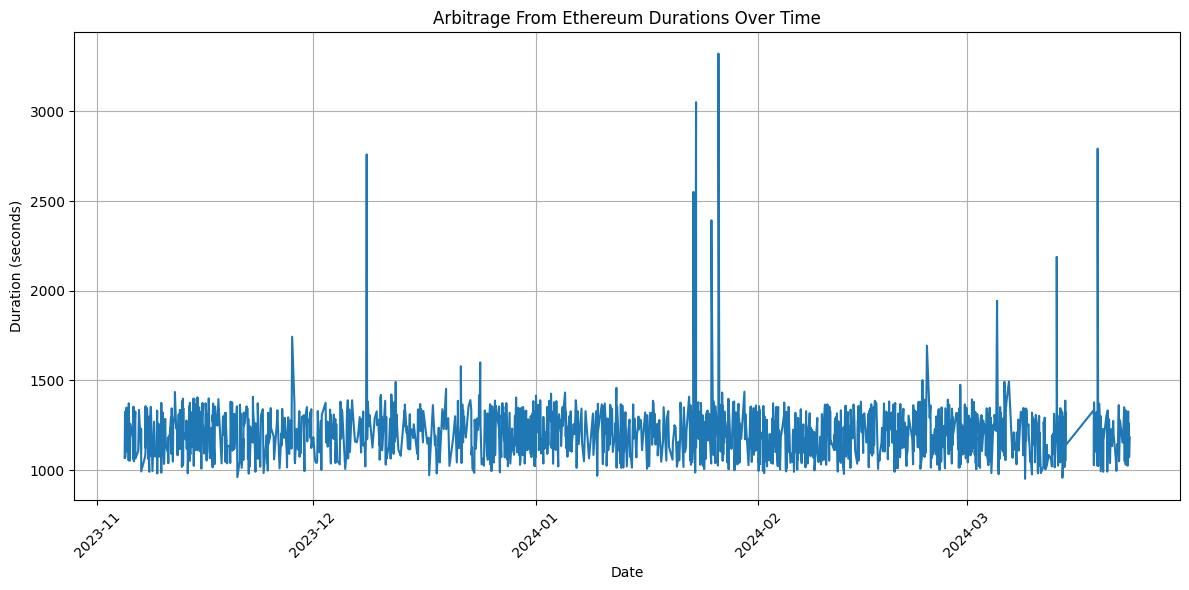

average durations 1208.964989059081


In [15]:
time_taken_for_arbitrage = {}
for i in range(len(cross_chain_mev_extractions)):
    if cross_chain_mev_extractions[i].direction is PolygonBridgeInteraction.FROM_ETHEREUM:
        time_taken_for_arbitrage[additional_info_ethereum[i][0]] = additional_info_polygon[i][0] - additional_info_ethereum[i][0]

timestamps = list(time_taken_for_arbitrage.keys())
durations = list(time_taken_for_arbitrage.values())
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

# Plotting the data
plt.figure(figsize=(12, 6))  # Set figure size (width, height)

plt.plot(dates, durations)  # Plotting the line chart

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration (seconds)')
plt.title('Arbitrage From Ethereum Durations Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()

print("average durations", sum(durations) / len(durations))

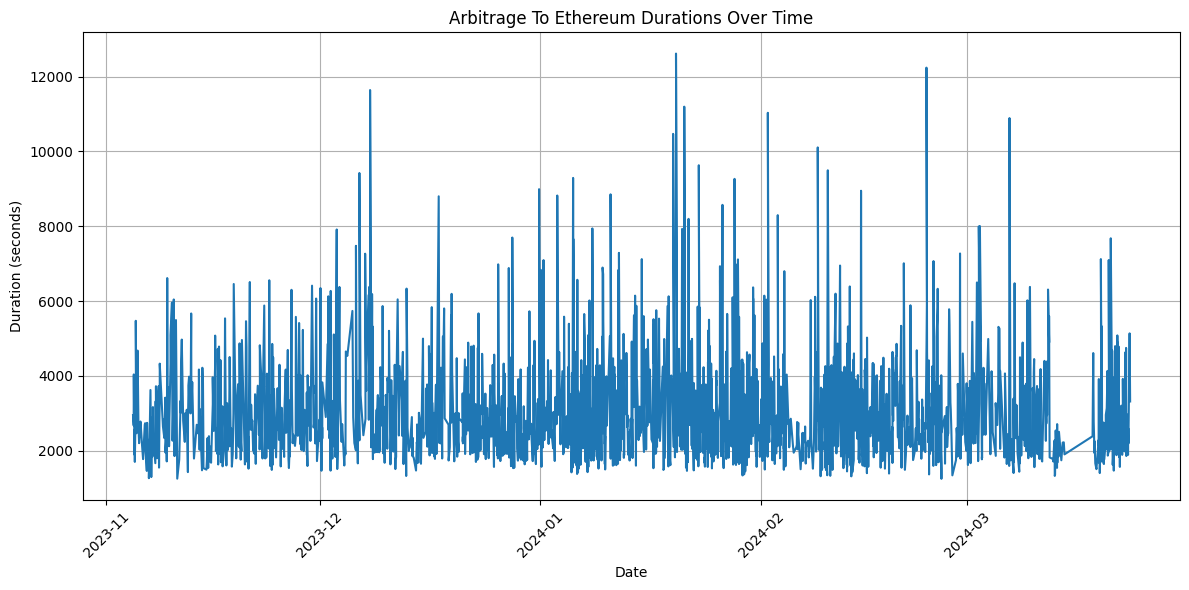

average durations 3017.5484606613454


In [16]:
time_taken_for_arbitrage = {}
for i in range(len(cross_chain_mev_extractions)):
    if cross_chain_mev_extractions[i].direction is PolygonBridgeInteraction.TO_ETHEREUM:
        time_taken_for_arbitrage[additional_info_polygon[i][0]] = additional_info_ethereum[i][0] - additional_info_polygon[i][0]

timestamps = list(time_taken_for_arbitrage.keys())
durations = list(time_taken_for_arbitrage.values())
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

# Plotting the data
plt.figure(figsize=(12, 6))  # Set figure size (width, height)

plt.plot(dates, durations)  # Plotting the line chart

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration (seconds)')
plt.title('Arbitrage To Ethereum Durations Over Time')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()

print("average durations", sum(durations) / len(durations))

In [17]:
print("number of cylic arbs:", len(cyclic_arbs), "out of", len(cross_chain_mev_extractions))

number of cylic arbs: 3901 out of 4488


In [18]:
no_of_profit_arbitrages = 0
for arb in cyclic_arbs:
    if float(arb.profit_amount) > 0:
        no_of_profit_arbitrages += 1
print("number of arbitrages in profit:", no_of_profit_arbitrages)
print("number of arbitrages in loss:", len(cyclic_arbs) - no_of_profit_arbitrages)

number of arbitrages in profit: 3311
number of arbitrages in loss: 590
